## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [656]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [657]:
# Read the CSV data & Read the first 5 rows
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [658]:
# View the shape of data 
df.shape[0]

294478

c. The number of unique users in the dataset.

In [659]:
# There is 290584 unique users
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [660]:
# About 12% of users converted
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [661]:
# Find the number of times a treatment was not associated with the new_page.
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [662]:
# check the missing values
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [663]:
# Create a new dataframe that removes the rows where the columns of treatment don't line up 
df2 = df[((df.group == 'treatment') & (df.landing_page == 'new_page')) | ((df.group == 'control') & (df.landing_page == 'old_page'))]

In [664]:
# Check again all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [665]:
# Find the number of unique values
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [666]:
# check the duplicate user_id
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [667]:
# Find the duplicate user_id
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [668]:
# Drop duplicate user_id
df2 = df2.drop_duplicates(subset='user_id');

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [669]:
# The probability of an individual converting regardless of the page they receive
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [670]:
# the probability that an individual in the control group converted
ctrl_converted = df2.query('group == "control"')['converted'].mean()

In [671]:
ctrl_converted

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [672]:
# the probability that an individual in the treatment group converted
trtm_converted = df2.query('group == "treatment"')['converted'].mean()

In [673]:
trtm_converted

0.11880806551510564

d. What is the probability that an individual received the new page?

In [674]:
# display the probability of receving new page
df2['landing_page'].value_counts()[0]/len(df2)

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

regard to the probabilities we calculated in the analysis above we see that the control groub has a slightly higher conversion rate 0.1203 than the treatment group 0.1188 , but the result don't give as a solid evidence to have more conversions after that we have to make hypothesis test to support our decision 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H_{0}$: $p_{new}$ - $p_{old}$ $\leq$ 0

$H_{1}$: $p_{new}$ - $p_{old}$ &gt; 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [675]:
# Calculate the converted rate for p_new 
p_new = df2.converted.mean()

In [676]:
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [677]:
# Calculate the converted rate for p_old 
p_old = df2.converted.mean()

In [678]:
p_old

0.11959708724499628

c. What is $n_{new}$?

In [679]:
# Find count of the new page
new_p = df2.query('landing_page == "new_page"')
n_new = new_p.shape[0]

In [680]:
n_new

145310

d. What is $n_{old}$?

In [681]:
# Find count of the old page
old_p = df2.query('landing_page == "old_page"')
n_old = old_p.shape[0]

In [682]:
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [683]:
# Simulate n_new transactions with a convert rate of p_new 
new_page_converted = np.random.choice([1,0], size=n_new, p=[p_new, 1-p_new]).mean()

In [684]:
new_page_converted 

0.12145069162480215

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [685]:
# Simulate n_new transactions with a convert rate of p_new 
old_page_converted = np.random.choice([1,0], size=n_old, p=(p_old, 1-p_old)).mean()

In [686]:
old_page_converted 

0.11839696022688162

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [687]:
# Find p_new - p_old 
obs_diff = trtm_converted - ctrl_converted

In [688]:
obs_diff

-0.0015782389853555567

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [689]:
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

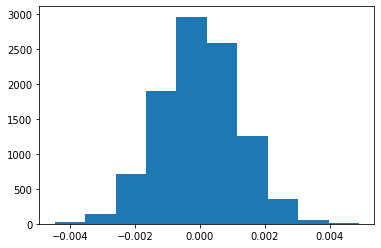

In [690]:
# Draw histogram of p_diffs
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [691]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

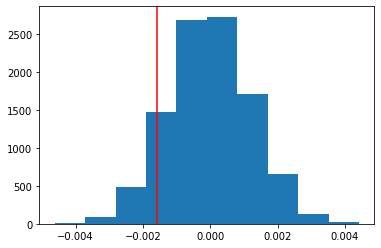

In [692]:
# plot null_vals 
plt.hist(null_vals)
plt.axvline(obs_diff, c='red');

In [693]:
# compute p value
(null_vals > obs_diff).mean()

0.9037

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?




The result above shows the p value of observing statistic given the null is true. As the p value is large enough

so we fail to reject the null hypothesis and keep the old page

 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [694]:
convert_old = df2.query('converted == 1 & landing_page == "new_page"')['user_id'].nunique()
convert_new = df2.query('converted == 1 & landing_page == "old_page"')['user_id'].nunique()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [695]:
# Find the p-value and z-score
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='larger')
print ('z-score:',z_score)
print ('p-value:',p_value)

z-score: -1.2616957421858055
p-value: 0.8964708551967226


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

****
we see that the z-score -1.26 and the p value approximately 0.90 which indicates weak evidence against the null hypothesis, so we fail to reject the null hypothesis, which is consistent with the results in parts j & k

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [696]:
# set the intercept  to 1 and  Creat ab_page column which is 1 when an individual receives the treatment and 0 control 
df2['intercept'] = 1 
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']

In [697]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [698]:
# import the regression model and fit using the intercept and ab_page 
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [699]:
# Display the result of the regression model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 30 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        22:36:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The difference is,  the p value associated with ab_page is 0.190. This p value differs from the value in Part II due to the null and alternative hypothesis changing
****

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Factors may contribute to the significance of our test results and leads to more accurate decisions.

The disadvantages of considering other factors is if the other factors are not closely correlated to the hypothesis you are testing then they can create an inaccurate result of the hypothesis testing, the weight of these other factors has to be taken into consideration so that minor factors don't affect the model as much as major factors.
****

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [700]:
# read the new dataset and make a relation between by using the join
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.tail()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,1,0
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,1,0
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,1,0
655535,CA,2017-01-09 13:30:47.524512,treatment,new_page,0,1,1
934996,UK,2017-01-09 00:30:08.377677,control,old_page,0,1,0


In [701]:
# Find the possible values for the country column
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [702]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [703]:
# dummy necessary variables
df_new[['US', 'UK']] = pd.get_dummies(df_new['country'])[['US', "UK"]]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [704]:
#create ab_page column 
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,US_ab_page,UK_ab_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [705]:
# import the and fit the model
logit2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK' , 'US_ab_page', 'UK_ab_page']])
result2 = logit2.fit()
# display the summry
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 Jun 2020   Pseudo R-squ.:               3.482e-05
Time:                        22:36:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

<a id='conclusions'></a>
## Conclusions

The results of the analysis indicate that there is not a significant difference in conversion rates between the new and old pages and as a result we are unable to reject the null hypothesis. 


Looking at the results above, we may conclude there is no significant effect on the convertion based on the country.

### References

https://www.youtube.com/watch?v=5FmxvmlOmfA

https://docs.w3cub.com/statsmodels/

https://scipy.org/

https://www.youtube.com/user/khanacademy
